In [72]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [107]:
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.Resize(size=(96,96)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [108]:
data = datasets.ImageFolder('data',transform=transform)
print(data)

Dataset ImageFolder
    Number of datapoints: 640
    Root Location: data
    Transforms (if any): Compose(
                             RandomHorizontalFlip(p=0.5)
                             RandomRotation(degrees=(-20, 20), resample=False, expand=False)
                             Resize(size=(96, 96), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None


In [109]:
batch_size = 32
# percentage of training set to use as validation
test_size = 0.3
valid_size = 0.1
#For test
num_data = len(data)
indices_data = list(range(num_data))
np.random.shuffle(indices_data)
split_tt = int(np.floor(test_size * num_data))
train_idx, test_idx = indices_data[split_tt:], indices_data[:split_tt]

#For Valid
num_train = len(train_idx)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)
split_tv = int(np.floor(valid_size * num_train))
train_new_idx, valid_idx = indices_train[split_tv:],indices_train[:split_tv]


# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_new_idx)
test_sampler = SubsetRandomSampler(test_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [110]:
train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
    sampler=train_sampler, num_workers=1)
valid_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(data, sampler = test_sampler, batch_size=batch_size, 
    num_workers=1)
classes = [0,1]

In [111]:
len(test_loader)*batch_size + len(valid_loader)*batch_size + len(train_loader)*batch_size

672

In [112]:
print(len(test_loader))

6


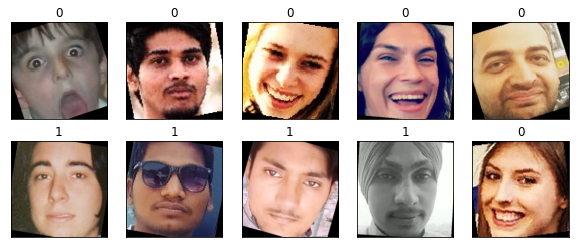

In [113]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(10, 4))
# display 20 images
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [114]:
import torch.nn as nn
import torch.nn.functional as F
train_on_gpu = torch.cuda.is_available()

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 5)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32*21*21, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, 2)
        self.softmax = nn.Softmax(dim=1)

        
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 32 * 21 * 21)
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.softmax(self.fc3(x))
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout(p=0.2)
  (fc1): Linear(in_features=14112, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
  (softmax): Softmax()
)


In [115]:
import torch.optim as optim

# specify loss function
criterion = torch.nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 0.003, momentum= 0.9)

In [116]:
n_epochs = 5 

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        

    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.431160 	Validation Loss: 0.046481
Validation loss decreased (inf --> 0.046481).  Saving model ...
Epoch: 2 	Training Loss: 0.415339 	Validation Loss: 0.044949
Validation loss decreased (0.046481 --> 0.044949).  Saving model ...
Epoch: 3 	Training Loss: 0.395593 	Validation Loss: 0.043549
Validation loss decreased (0.044949 --> 0.043549).  Saving model ...
Epoch: 4 	Training Loss: 0.379920 	Validation Loss: 0.043211
Validation loss decreased (0.043549 --> 0.043211).  Saving model ...
Epoch: 5 	Training Loss: 0.374825 	Validation Loss: 0.043264


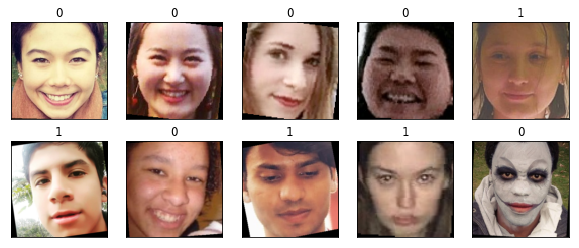

In [117]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
# obtain one batch of training images

dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(10, 4))
# display 20 images
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [118]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
i=1
# iterate over test data

for data, target in test_loader:
    i=i+1
    if len(target)!=batch_size:
        continue
        
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    print(output,target)
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
#     print(target)
    
    for i in range(batch_size):       
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

#print(correct)

tensor([[0.9636, 0.0364],
        [0.9365, 0.0635],
        [0.8956, 0.1044],
        [0.9169, 0.0831],
        [0.9131, 0.0869],
        [0.9118, 0.0882],
        [0.9130, 0.0870],
        [0.9466, 0.0534],
        [0.9510, 0.0490],
        [0.9320, 0.0680],
        [0.9642, 0.0358],
        [0.9613, 0.0387],
        [0.9335, 0.0665],
        [0.9623, 0.0377],
        [0.9203, 0.0797],
        [0.9459, 0.0541],
        [0.9203, 0.0797],
        [0.9029, 0.0971],
        [0.9575, 0.0425],
        [0.9181, 0.0819],
        [0.9278, 0.0722],
        [0.9045, 0.0955],
        [0.9596, 0.0404],
        [0.9437, 0.0563],
        [0.9519, 0.0481],
        [0.9408, 0.0592],
        [0.9031, 0.0969],
        [0.8817, 0.1183],
        [0.9711, 0.0289],
        [0.9503, 0.0497],
        [0.9473, 0.0527],
        [0.9624, 0.0376]], grad_fn=<SoftmaxBackward>) tensor([0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1,
        0, 1, 1, 0, 0, 0, 1, 1])
tensor([[0.9306, 0.0694],
 

In [119]:
for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Accuracy of     0: 100% (102/102)
Test Accuracy of     1:  0% ( 0/90)

Test Accuracy (Overall): 53% (102/192)


In [120]:
from PIL import Image
test_img = Image.open("59.jpg")

In [121]:
def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = transform(image).float()
    image = image.unsqueeze(0)
    return image

image = image_loader("59.jpg")

output = model(image)
print(output)

tensor([[0.9307, 0.0693]], grad_fn=<SoftmaxBackward>)
